# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#установка библиотек
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import time

In [4]:
#размер графиков
sns.set(rc={"figure.figsize":(12, 6)})
#темная тема для графиков
plt.style.use('dark_background')

In [5]:
df = pd.read_csv('https://code.s3.yandex.net//datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.duplicated().sum()

4

В нашем датасете примерно 350 тысячами записей об автомобилях. В некоторых колнках довольно много пропусков данных, которые надо будет обработать. Имеются 4 дупликата, которые можно удалить. Для некоторых колонок необходимо поменяь тип данных.

<b>Признаки:</b>

DateCrawled — дата скачивания анкеты из базы<br>
VehicleType — тип автомобильного кузова<br>
RegistrationYear — год регистрации автомобиля<br>
Gearbox — тип коробки передач<br>
Power — мощность (л. с.)<br>
Model — модель автомобиля<br>
Kilometer — пробег (км)<br>
RegistrationMonth — месяц регистрации автомобиля<br>
FuelType — тип топлива<br>
Brand — марка автомобиля<br>
NotRepaired — была машина в ремонте или нет<br>
DateCreated — дата создания анкеты<br>
NumberOfPictures — количество фотографий автомобиля<br>
PostalCode — почтовый индекс владельца анкеты (пользователя)<br>
LastSeen — дата последней активности пользователя<br>

<b>Целевой признак:</b>

Price — цена (евро)

## EDA

Удалим дубликатф

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
#проверим
df.duplicated().sum()

0

### DateCrawled, DateCreated, LastSeen, PostalCode

Поменяем тип данных в столюцах "DateCrawled", "DateCreated", "LastSeen" и проанализируем данные в этих столбцах

In [10]:
df[["DateCrawled", "DateCreated", "LastSeen"]] = df[["DateCrawled", "DateCreated", "LastSeen"]].apply(pd.to_datetime)
df['LastSeen'].describe(datetime_is_numeric=True)

count                           354365
mean     2016-03-29 23:51:06.766184960
min                2016-03-05 14:15:08
25%                2016-03-23 02:50:03
50%                2016-04-03 15:15:52
75%                2016-04-06 10:15:19
max                2016-04-07 14:58:51
Name: LastSeen, dtype: object

Даты последней активности пользователей с 2016-03-05 по 2016-04-07 и следовательно даты выгружены из базы примерно 2016-04-07

In [11]:
df['DateCrawled'].describe(datetime_is_numeric=True)

count                           354365
mean     2016-03-21 12:58:09.520460544
min                2016-03-05 14:06:22
25%                2016-03-13 11:52:33
50%                2016-03-21 17:50:55
75%                2016-03-29 14:37:20
max                2016-04-07 14:36:58
Name: DateCrawled, dtype: object

In [12]:
df['DateCreated'].describe(datetime_is_numeric=True)

count                           354365
mean     2016-03-20 19:12:06.583042560
min                2014-03-10 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: DateCreated, dtype: object

По сути столбцы "DateCrawled", "DateCreated", "LastSeen" не будут полезны для обучения модели. Также удалим PostalCode данные в этом столбце не важны для обучения моедли

In [13]:
df = df.drop(['DateCreated', 'PostalCode', 'LastSeen', 'DateCrawled'], axis=1)

In [14]:
#проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            334532 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  NotRepaired        283211 non-null  object
 11  NumberOfPictures   354365 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 35.1+ MB


Заполним пропущенные значения и обработаем аномалии в столбцах. Начнем со столбца RegistrationYear

### RegistrationYear

In [15]:
df['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [16]:
#исходное кол-во данных в RegistrationYear
df_RegYear_initial = df['RegistrationYear'].count()
df_RegYear_initial

354365

Первый автомобиль был сделан в 1885 году https://ru.wikipedia.org/wiki/Benz_Patent-Motorwagen, в нашем распоряженни данные выгруженные в авпреле 2016 года, следовательно машины с годом выпуска менее 1985 и более 2016 это выбросы(ошибки).

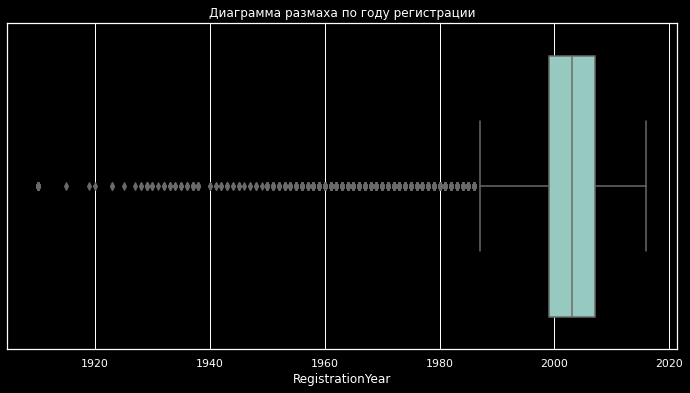

In [17]:
df = df[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] >= 1885)]
sns.boxplot(x='RegistrationYear', data=df)
plt.title('Диаграмма размаха по году регистрации')
plt.show()

In [18]:
round((df_RegYear_initial - df['RegistrationYear'].count())*100/df_RegYear_initial, 2)

4.12

Мы удалили порядка 4% данных. Также проанализировов значния по диаграмме "ящик с усами" можем заметить, что машин с годом выпуска менее 1980 года не так и много.

In [19]:
round(100*df[df['RegistrationYear'] < 1980]['RegistrationYear'].count()/df['RegistrationYear'].count(), 2)

1.0

Таких данных примерно 1%. И действительно машин этого года выпуска крайне мало на дорогах. Также удалим их.

In [20]:
df = df[df['RegistrationYear'] >= 1980]

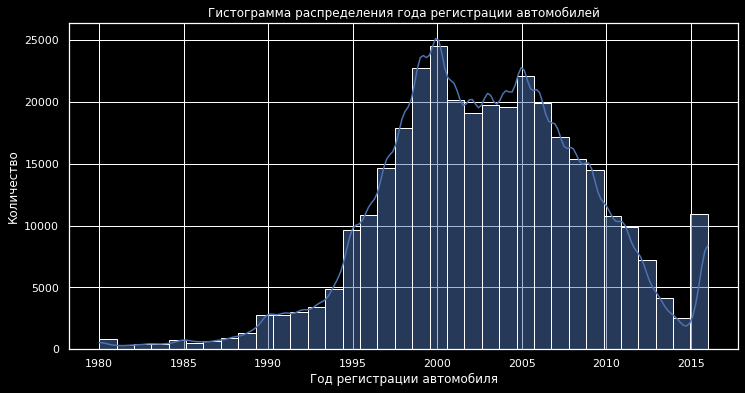

In [21]:
sns.histplot(data=df, x='RegistrationYear', 
             kde=True, bins=35).set(
    title='Гистограмма распределения года регистрации автомобилей',
    xlabel='Год регистрации автомобиля',
    ylabel='Количество')
plt.show()

In [22]:
round((df_RegYear_initial - df['RegistrationYear'].count())*100/df_RegYear_initial, 2)

5.07

В сумме после работы со столбцом RegistrationYear мы убрали примерно 5% данных. Левый хвост рспределения немного великоват и 2016 год похож не выброс, но в остальном распределение очень даже похоже на нормальное.

### Price

[Text(0.5, 0, 'Цена автомобиля')]

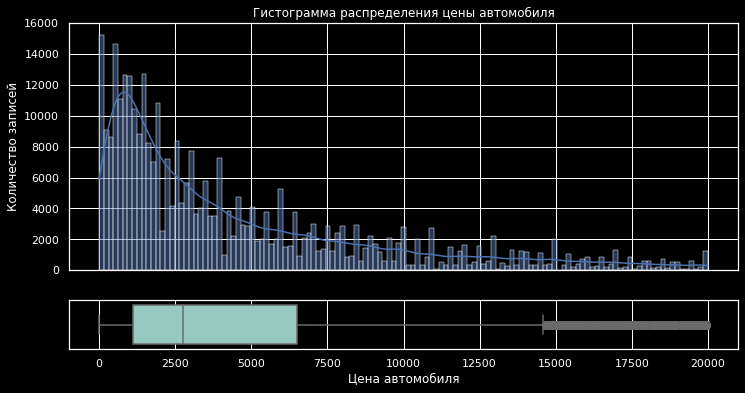

In [23]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(12, 6), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=df, x='Price', kde=True, ax=axs_hist)
box = sns.boxplot(data=df, x='Price', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения цены автомобиля',
         ylabel='Количество записей')
box.set(xlabel='Цена автомобиля')

In [24]:
df['Price'].describe()

count    336383.000000
mean       4447.299444
std        4526.699583
min           0.000000
25%        1099.000000
50%        2750.000000
75%        6499.000000
max       20000.000000
Name: Price, dtype: float64

Цены на автомобили начинаются от 0, это видимо машины в очень плохом состоянии, также в таблице присутствуют очень дорогие машины, намного дороже "основной массы" для чистоты анализа и нацеленности нашей моедли на основной сегмент удалим 1% от данный "сверху" и "снизу".

In [25]:
#исходное кол-во данных в Price
df_Price_initial = df['Price'].count()

In [26]:
df=df[(df['Price'] > df['Price'].quantile(.01)) & (df['Price'] < df['Price'].quantile(.99))]

In [27]:
round((df_Price_initial - df['Price'].count())*100/df_RegYear_initial, 2)

3.7

[Text(0.5, 0, 'Цена автомобиля')]

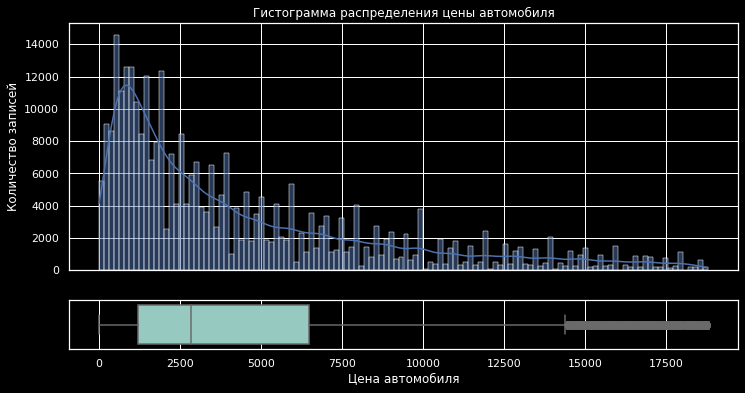

In [28]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(12, 6), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = sns.histplot(data=df, x='Price', kde=True, ax=axs_hist)
box = sns.boxplot(data=df, x='Price', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения цены автомобиля',
         ylabel='Количество записей')
box.set(xlabel='Цена автомобиля')

### Power

In [29]:
df['Power'].describe()

count    323269.000000
mean        111.389911
std         183.961427
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Самый мощный гиперкар на 2016 год Bugatti Chiron имеет мощность 1500 л.с. https://motor.ru/lab/chiron.htm
Посмотри сколько записей превашающает этот порог. Возможно это ошибки в записи,  возможно это тюнингованные автомобили.

In [30]:
df[df['Power'] > 1500]['Power'].count()

171

не много, просто отбросим эти данные

In [31]:
df = df[df['Power'] <= 1500]

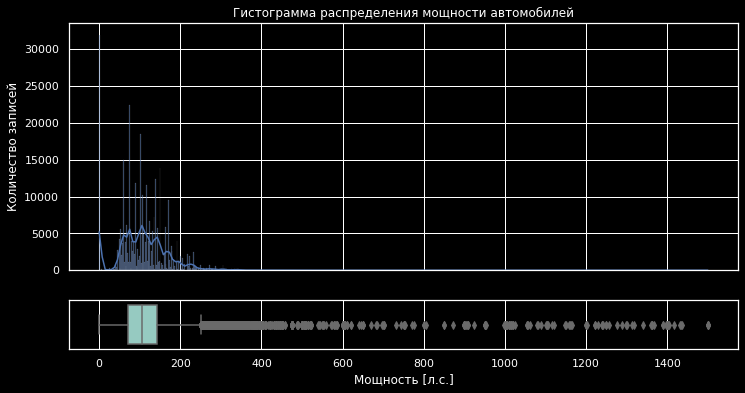

In [32]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(12, 6), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[5,1]))
hist = \
sns.histplot(data=df, x='Power', 
             kde=True, ax=axs_hist)
box = sns.boxplot(data=df, x='Power', orient='h', ax=axs_box)
box.set(xlabel='Мощность [л.с.]')
hist.set(title='Гистограмма распределения мощности автомобилей',
         ylabel='Количество записей');

Мы видим большой пик в районе 0, возможно это автомобили без двигателя. 

In [33]:
round(df[df['Power'] == 0]['Power'].count() * 100 / df['Power'].count(), 2)

9.87

Машин без с мощностью 0 практически 10%. Сомневаюсь, что это похоже на правду. Но оставим пока это как есть.
Если посмотреть на гисторгамму мы можем увидеть, что машин с мощностью более 400 не так уж и много

In [34]:
df[df['Power'] > 400]['Power'].count()

422

422 шт. это скорее редкость Уберем их. Будем ориентировать нашу модель на "основной" сегмент, а уже потом при необходимости будем модернизировать.

In [35]:
df = df[df['Power'] <= 400]

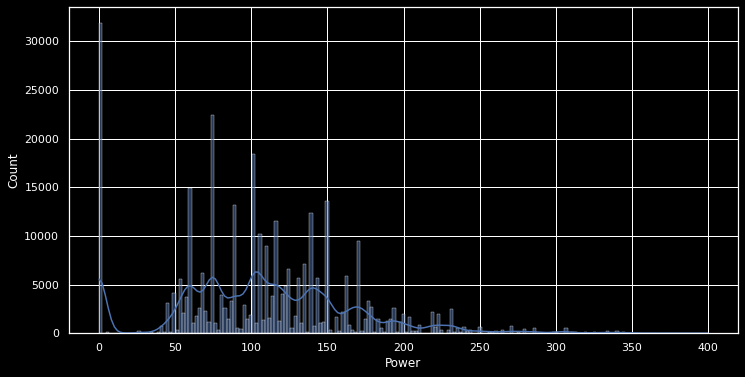

In [36]:
sns.histplot(data=df, x='Power', kde=True)
hist.set(title='Гистограмма распределения мощности автомобилей',
         ylabel='Количество записей',
         xlabel='Мощность [л.с.]');

### NotRepaired

In [37]:
df['NotRepaired'].value_counts(normalize=True, dropna=False)

no     0.717401
NaN    0.181752
yes    0.100847
Name: NotRepaired, dtype: float64

В имеющихся данных больше всего данных о не ремонтировавшихся автомобилях. У нас также имеется примерно 20 процентов данных с пропусками данных. Пропусков очень много, так что просто отбросить данные мы не можем. Колонка очень важная для определения стоимости автомобиля, заполнение пропусков самым часто встречающися значением может привести к сильным искажениям. Поэтому отметим все пропуски значением unknown (неизвестно)

In [38]:
df['NotRepaired'] = df['NotRepaired'].fillna(value='unknown')

In [39]:
#проверим
df['NotRepaired'].value_counts(normalize=True, dropna=False)

no         0.717401
unknown    0.181752
yes        0.100847
Name: NotRepaired, dtype: float64

### VehicleType 

In [40]:
df['VehicleType'].value_counts(normalize=True, dropna=False)

sedan          0.270352
small          0.240346
wagon          0.194802
bus            0.086322
NaN            0.060727
convertible    0.058783
coupe          0.045302
suv            0.034369
other          0.008997
Name: VehicleType, dtype: float64

В столбце порядка 6% пропусков. Попробуем заполнить пропуски по взаимосвязи со столбцом Model. Как правило у одной моедли один тип кузова.

In [41]:
#для упрощения работы заменим пропуски pyfxtybtv unknown
df['Model'] = df['Model'].fillna('unknown')
df['VehicleType'] = df['VehicleType'].fillna('unknown')

In [42]:
#Создадим словарь модель тип кузова 
models_vehType = df.groupby('Model')['VehicleType'].agg(lambda x:x.value_counts().index[0]).to_dict()

In [43]:
#функция заменяет пропуски (значения unknown) в VehicleType
#на значения из словаря models_vehTypeg по модели авто
def vehicle_type_inputer(row):
    
    model = row['Model']
    veh_Type = row['VehicleType']
    
    if model == 'unknown' and veh_Type == 'unknown':
        return 'unknown'
    elif model == 'unknown' and veh_Type != 'unknown':
        return veh_Type
    
    return models_vehType[model]

df['VehicleType'] = df[['VehicleType', 'Model']].apply(vehicle_type_inputer, axis=1)

In [44]:
#проверим
df['VehicleType'].value_counts(normalize=True, dropna=False)

sedan          0.438040
small          0.249535
wagon          0.152388
bus            0.082318
suv            0.030135
convertible    0.018189
coupe          0.016605
unknown        0.011597
other          0.001193
Name: VehicleType, dtype: float64

Осталось порядка 1 % значений unknown. Оставим эти данные без имзенений

In [45]:
df.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox              14996
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             23471
Brand                    0
NotRepaired              0
NumberOfPictures         0
dtype: int64

### Gearbox

In [46]:
df['Gearbox'].value_counts(normalize=True, dropna=False)

manual    0.766493
auto      0.187033
NaN       0.046474
Name: Gearbox, dtype: float64

В столбце порядка 4% пропусков. В данном случае мы не можем дейстовать также как поступили со столбцом VehicleType, так как одна и таже модель может быть с разной коробкой преедач, поэтому заменим значение на manual, так как этого типа коробок в данных 76% данное действие, несильно поменят картину 

In [47]:
df['Gearbox'] = df['Gearbox'].fillna('manual')

In [48]:
#проверим
df['Gearbox'].value_counts(normalize=True, dropna=False)

manual    0.812967
auto      0.187033
Name: Gearbox, dtype: float64

Gропуски в столбце Gearbox заполнены

### FuelType

Самый распространенный тип топлива бензин, поэтому заполним пропуски в столбце FuelType на petrol

In [49]:
df['FuelType'].value_counts(normalize=True, dropna=False)

petrol      0.621335
gasoline    0.287555
NaN         0.072739
lpg         0.015396
cng         0.001636
hybrid      0.000657
other       0.000425
electric    0.000257
Name: FuelType, dtype: float64

7% пропусков. Заполним пропуски по самому рапространеному типу топлива petrol(он же gasoline в сумме 90%)

In [50]:
df['FuelType'] = df['FuelType'].fillna('petrol')

In [51]:
#проверим количество пропусков в df
df.isna().sum().sum()

0

Больше пропусков в df нет

### Kilometer

In [52]:
df['Kilometer'].describe()

count    322676.000000
mean     129037.316069
std       36770.750773
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

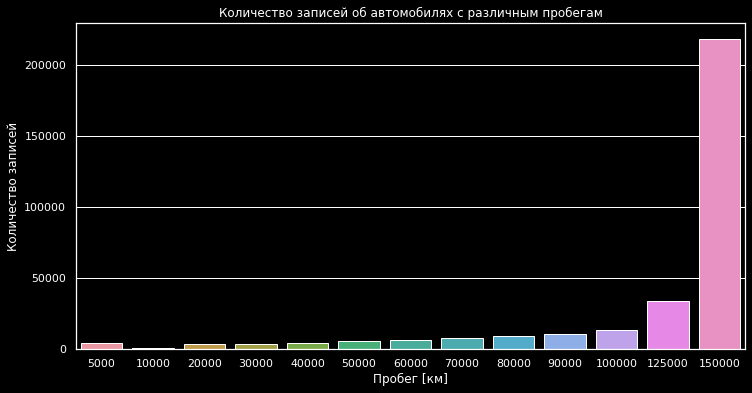

In [53]:
sns.countplot(data=df, x='Kilometer')\
.set(title='Количество записей об автомобилях с различным пробегам',
    xlabel='Пробег [км]',
    ylabel='Количество записей');

In [54]:
df['Kilometer'].value_counts()

150000    218411
125000     33720
100000     13406
90000      10625
80000       9185
70000       7847
60000       6810
50000       5573
5000        4491
40000       4415
30000       3887
20000       3368
10000        938
Name: Kilometer, dtype: int64

Столбец Kilometer является категориальным, машин с пробегом 150000 намного больше других, вилимо это макисмальная категория на плотформе, где регистрировались объявления.

### RegistrationMonth  

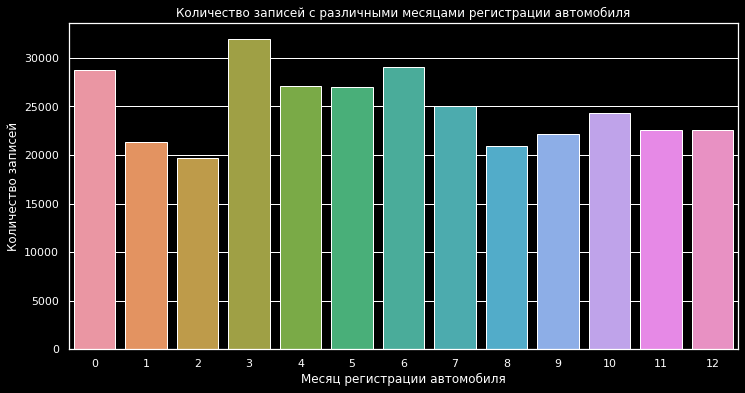

In [55]:
sns.countplot(data=df, x='RegistrationMonth')\
.set(xlabel='Месяц регистрации автомобиля',
     ylabel='Количество записей',
     title='Количество записей с различными месяцами регистрации автомобиля');

Во первых почему-то в нашем df 13 месяцев, во вторых этот столбец с точки зрения обучения модели наврядли нужен, поэтому удалим его.

In [56]:
df = df.drop('RegistrationMonth', axis=1)

In [57]:
#проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322676 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             322676 non-null  int64 
 1   VehicleType       322676 non-null  object
 2   RegistrationYear  322676 non-null  int64 
 3   Gearbox           322676 non-null  object
 4   Power             322676 non-null  int64 
 5   Model             322676 non-null  object
 6   Kilometer         322676 non-null  int64 
 7   FuelType          322676 non-null  object
 8   Brand             322676 non-null  object
 9   NotRepaired       322676 non-null  object
 10  NumberOfPictures  322676 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 37.6+ MB


### Brand

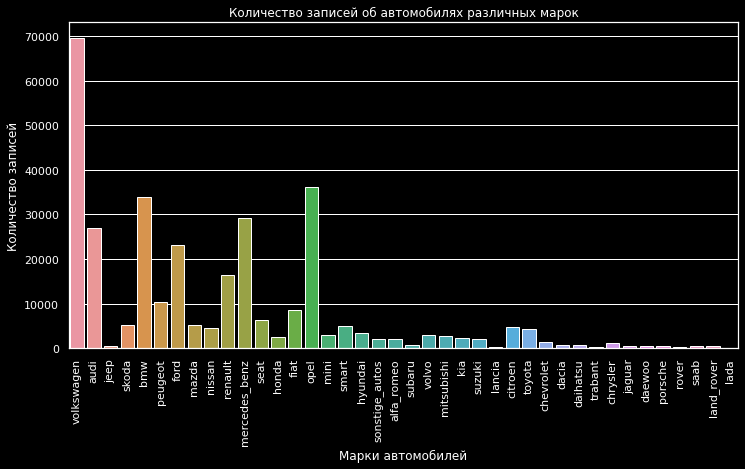

In [58]:
sns.countplot(data=df, x='Brand')\
.set(xlabel='Марки автомобилей',
     ylabel='Количество записей',
     title='Количество записей об автомобилях различных марок')
plt.xticks(rotation=90);

In [59]:
len(df['Brand'].unique())

40

В нашем df 40 автомобильных брендов. Эта колонка будет весьма полезна при обучении модели

### NumberOfPictures  

In [60]:
df['NumberOfPictures'].value_counts()

0    322676
Name: NumberOfPictures, dtype: int64

Одно значение для всех записей. Удаляем данный признак.

In [61]:
df.drop('NumberOfPictures', axis=1, inplace=True)

In [62]:
#проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322676 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             322676 non-null  int64 
 1   VehicleType       322676 non-null  object
 2   RegistrationYear  322676 non-null  int64 
 3   Gearbox           322676 non-null  object
 4   Power             322676 non-null  int64 
 5   Model             322676 non-null  object
 6   Kilometer         322676 non-null  int64 
 7   FuelType          322676 non-null  object
 8   Brand             322676 non-null  object
 9   NotRepaired       322676 non-null  object
dtypes: int64(4), object(6)
memory usage: 35.1+ MB


In [63]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,sedan,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<b>Вывод по разделу:</b><br>
В ходе исследовательского анализа данных были заполнены пропущенные значения и обработаны аномалии в столбцах. Удалены неинформативные для дальнейшей работы данные.

## Подготовка выборок

Выполним one hot encoding категориальных переменных для обучения линейной регрессии

In [64]:
df_ohe=df.copy()
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

Для моделей на основе деревьев закодируем данные с помощью James-Stein Encoder. Данный Encoder был выбран в соответствиии со схемой https://yandex.ru/images/search?text=categorical%20encoding&lr=213&from=tabbar&pos=0&img_url=http%3A%2F%2Fmiro.medium.com%2Fmax%2F1400%2F1*Br3ZcQIf95TvcQozWctgIA.png&rpt=simage

In [65]:
df_jse = df.copy()
cat_jse = df_jse.select_dtypes(include='object').columns.to_list()
cat_jse

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [66]:
jse = ce.JamesSteinEncoder(cols=cat_jse)
df_jse_tranformed = jse.fit_transform(df_jse, df_jse['Price'])

In [67]:
#проверка
df_jse_tranformed.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,4473.883585,1993,3907.911015,0,4316.886309,150000,3822.811586,4422.454441,2728.160145
1,18300,6434.630302,2011,3907.911015,190,3564.598969,125000,5736.691864,5228.287977,1981.223257
2,9800,7223.884599,2004,6638.912330,163,5429.467287,125000,5736.691864,5684.128510,2728.160145
3,1500,4473.883585,2001,3907.911015,75,4316.886309,150000,3822.811586,4422.454441,5189.635579
4,3600,3331.630785,2008,3907.911015,69,4289.003471,90000,5736.691864,5200.791737,5189.635579


Для LightGBM пометим категориальные переменные

In [68]:
for col in df.select_dtypes(include=['object']):
  df[col] = df[col].astype('category')

In [69]:
#проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322676 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             322676 non-null  int64   
 1   VehicleType       322676 non-null  category
 2   RegistrationYear  322676 non-null  int64   
 3   Gearbox           322676 non-null  category
 4   Power             322676 non-null  int64   
 5   Model             322676 non-null  category
 6   Kilometer         322676 non-null  int64   
 7   FuelType          322676 non-null  category
 8   Brand             322676 non-null  category
 9   NotRepaired       322676 non-null  category
dtypes: category(6), int64(4)
memory usage: 22.5 MB


Разделим данные на обучающую, валидационную и тестовую выборки.

In [70]:
#фнкция для разделения данных
def make_split(df):
  X = df.drop('Price',axis=1)
  y = df['Price']
  X_except, X_valid, y_except, y_valid = train_test_split(X, y, test_size = 0.2, random_state=46)
  X_train, X_test, y_train, y_test = train_test_split(X_except, y_except, test_size = 0.25, random_state=46)
  return X_train, X_valid, X_test, y_train, y_valid, y_test

In [71]:
X_train, X_valid, X_test, y_train, y_valid, y_test = make_split(df)
X_train_ohe, X_valid_ohe, X_test_ohe, y_train_ohe, y_valid_ohe, y_test_ohe = make_split(df_ohe)
X_train_jse, X_valid_jse, X_test_jse, y_train_jse, y_valid_jse, y_test_jse = make_split(df_jse)

In [72]:
#проверка
features = [X_train, X_valid, X_test, X_train_ohe, X_valid_ohe, X_test_ohe, X_train_jse, X_valid_jse, X_test_jse]
[x.shape for x in features]

[(193605, 9),
 (64536, 9),
 (64535, 9),
 (193605, 307),
 (64536, 307),
 (64535, 307),
 (193605, 9),
 (64536, 9),
 (64535, 9)]

In [73]:
#проверка
targets = [y_train, y_valid, y_test, y_train_ohe, y_valid_ohe, y_test_ohe, y_train_jse, y_valid_jse, y_test_jse]
[x.mean() for x in targets]

[4414.790682058831,
 4409.595899962811,
 4439.521561943132,
 4414.790682058831,
 4409.595899962811,
 4439.521561943132,
 4414.790682058831,
 4409.595899962811,
 4439.521561943132]

<b>Вывод по разделу:</b><br>
Подготовлены выборок для обучения моделей.

## Обучение моделей

Создадим функцию для подсчет времени обучения/ модели

In [ ]:
def learn_time(model,x_train,y_train):
    start = time.time()
    model.fit(x_train,y_train)
    end = time.time()
    time_fit = end - start
    return time_fit,model

Создадим функцию для  подсчета времени на предсказание

In [ ]:
def predict_time(model,x_valid):
    start = time.time()
    predict = model.predict(x_valid)
    end = time.time()
    time_predict= end - start
    return time_predict,predict

Создадим data frame для сбора результатов обучения и функцию для сбора

In [ ]:
model_result = pd.DataFrame(columns=['RMSE','learning time','predict time'])

In [ ]:
def cars_metrics(RMSE,l_time,p_time,model_name,df):
    df.loc[model_name,'RMSE'] = RMSE
    df.loc[model_name,'learning time'] = l_time
    df.loc[model_name,'predict time'] = p_time
    return df

Функция для обучения линейных моделей

In [ ]:
def model_work_ohe (model, name):
    model_learn_time,model1 = learn_time(model,X_train_ohe,y_train_ohe)
    model_pred_time,model_predict = predict_time(model1,X_valid_ohe)
    RMSE = np.sqrt(mean_squared_error(y_valid_ohe, model_predict))
    return cars_metrics(RMSE,model_learn_time,model_pred_time, name, model_result)

Функция для обучения моделей на основе деревьев

In [ ]:
def model_work_jse (model, name):
    model_learn_time,model1 = learn_time(model,X_train_jse,y_train_jse)
    model_pred_time,model_predict = predict_time(model1,X_valid_jse)
    RMSE = np.sqrt(mean_squared_error(y_valid_jse, model_predict))
    return cars_metrics(RMSE,model_learn_time,model_pred_time, name, model_result)

Функция для обучения LightGBM

In [ ]:
def model_work (model, name):
    model_learn_time,model1 = learn_time(model,X_train,y_train)
    model_pred_time,model_predict = predict_time(model1,X_valid)
    RMSE = np.sqrt(mean_squared_error(y_valid, model_predict))
    return cars_metrics(RMSE,model_learn_time,model_pred_time, name, model_result)

### Линейная регрессия

In [ ]:
model_work_ohe(LinearRegression(), 'LinearRegression')

,RMSE,learning time,predict time
LinearRegression,2482.556381,6.153191,0.126629


### Decision Tree

In [ ]:
model_work_jse(DecisionTreeRegressor(), 'DecisionTreeRegressor')

,RMSE,learning time,predict time
LinearRegression,2482.556381,6.153191,0.126629
DecisionTreeRegressor,1848.013784,0.861583,0.037563


### Random forest regressor

In [ ]:
params_rfc = {
    "n_estimators" : [10, 100],
    "max_depth": [None, 2,5], 
              }
rfc = RandomForestRegressor(random_state=46)
grid_rfc= GridSearchCV(estimator=rfc, scoring='neg_mean_squared_error', param_grid=params_rfc)
grid_rfc.fit(X_train_jse,  y_train_jse)
print('Best RMSE: %.2f'%((grid_rfc.best_score_*(-1))**0.5), ' Best Params : ', str(grid_rfc.best_params_))

Best RMSE: 1575.97  Best Params :  {'max_depth': None, 'n_estimators': 100}


In [ ]:
model_work_jse(RandomForestRegressor(random_state=46, **grid_rfc.best_params_), 'RandomForestRegressor')

,RMSE,learning time,predict time
LinearRegression,2482.556381,6.153191,0.126629
DecisionTreeRegressor,1848.013784,0.861583,0.037563
RandomForestRegressor,1551.003867,53.213712,2.969017


### LightGBM

Подбор гиперпараметров с помощью GridSearchSV

In [ ]:
params_lgbm = {
    "n_estimators" : [10, 50, 100],
    "max_depth": [-1, 3, 5]
              }
lgbm = LGBMRegressor(random_state=46)
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=params_lgbm, scoring='neg_mean_squared_error')
grid_lgbm.fit(X_train, y_train)
print('Best RMSE: %.2f'%((grid_lgbm.best_score_*(-1))**0.5), ' Best Params : ', str(grid_lgbm.best_params_))

Best RMSE: 1583.17  Best Params :  {'max_depth': -1, 'n_estimators': 100}


In [ ]:
model_work(LGBMRegressor(random_state=46, **grid_lgbm.best_params_), 'LGBMRegressor')

,RMSE,learning time,predict time
LinearRegression,2482.556381,6.153191,0.126629
DecisionTreeRegressor,1848.013784,0.861583,0.037563
RandomForestRegressor,1551.003867,53.213712,2.969017
LGBMRegressor,1582.148923,1.635085,0.388534


### Catboost

Подбор гиперпараметров с помощью RandomizedSearchCV

In [ ]:
cat = CatBoostRegressor(silent=True, random_state=46)
grid_cat = GridSearchCV(estimator=cat, param_grid = {'learning_rate': [0.03, 0.1]}, scoring='neg_mean_squared_error')
grid_cat.fit(X_train, y_train, cat_features=cat_jse)
print('Best RMSE: %.2f'%((grid_cat.best_score_*(-1))**0.5), ' Best Params : ', str(grid_cat.best_params_))

Best RMSE: 1565.88  Best Params :  {'learning_rate': 0.1}


In [ ]:
model_work(CatBoostRegressor(silent=True, random_state=46, learning_rate=0.1, cat_features=cat_jse), 'CatBoostRegressor')

,RMSE,learning time,predict time
LinearRegression,2482.556381,6.153191,0.126629
DecisionTreeRegressor,1848.013784,0.861583,0.037563
RandomForestRegressor,1551.003867,53.213712,2.969017
LGBMRegressor,1582.148923,1.635085,0.388534
CatBoostRegressor,1562.511468,168.187934,0.395107


## Анализ моделей

Проведем сравнение наших моделей по трем показателям RMSE,	learning time,	predict time

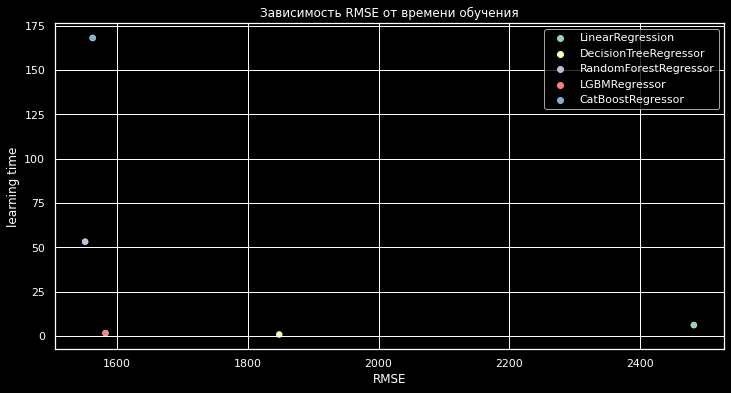

In [ ]:
legend=model_result.index.values.tolist()
sns.scatterplot(data = model_result ,x ='RMSE', y='learning time', hue=legend)
plt.title('Зависимость RMSE от времени обучения')
plt.show()

Из графика зависимость RMSE от времени обучения следует что модель LGBMRegressor наиболее эффективна на валидационной выборке

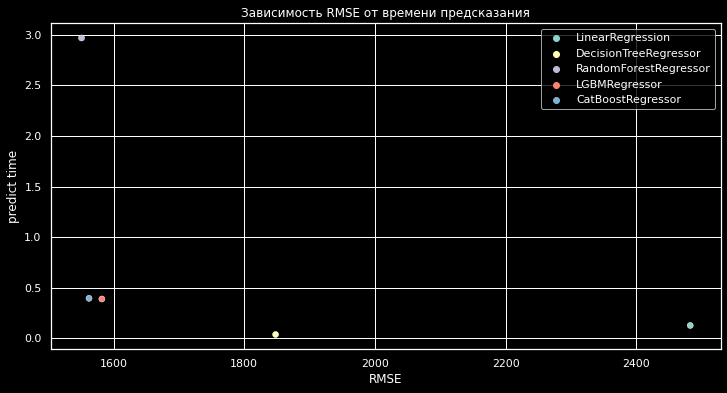

In [ ]:
sns.scatterplot(data = model_result ,x ='RMSE', y='predict time', hue=legend)
plt.title('Зависимость RMSE от времени предсказания')
plt.show()

Из графика зависимость RMSE от времени предсказания следует что модель CatBoostRegressor и LGBMRegressor наиболее эффективные на валидационной выборке

Выполним тестирование модели LGBMRegressor на тестовой выборке. Предварительно переобучим моедль на выборках train и valid вместе.

In [ ]:
X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train, y_valid])

In [ ]:
lgbm = LGBMRegressor(random_state=46, **grid_lgbm.best_params_)
model_learn_time, model1 = learn_time(lgbm,X_train_valid,y_train_valid)
model_pred_time,model_predict = predict_time(model1,X_test)
RMSE = np.sqrt(mean_squared_error(y_test, model_predict))
print('Результаты тестирования: RMSE:', round(RMSE), 'Время обучения: ', round(model_learn_time, 2),'Время предсказания: ', round(model_pred_time, 2))

Результаты тестирования: RMSE: 1573 Время обучения:  2.08 Время предсказания:  0.38


Посмотрим важность признаков для модели LightGBM

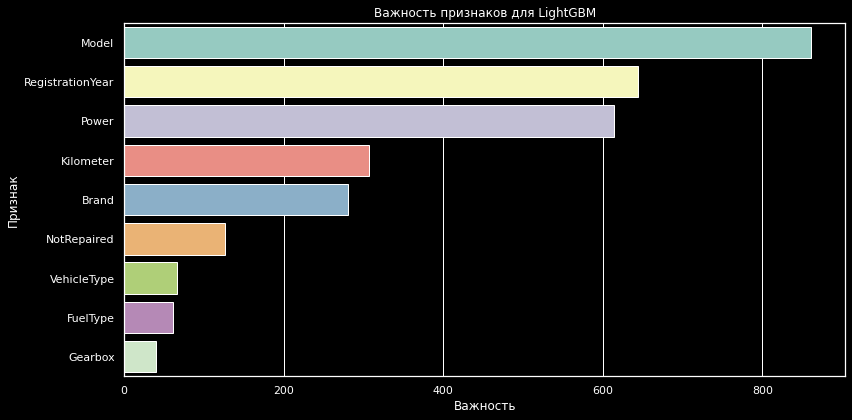

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X_train_valid)), columns=['Важность','Признак'])
sns.barplot(x="Важность", y="Признак", data=feature_imp.sort_values(by="Важность", ascending=False))
plt.title('Важность признаков для LightGBM')
plt.tight_layout()
plt.show()

<b>Вывод по разделу:</b><br>
Проведено тестирование наилучшей моедли исходя из критериев заказчика (RMSE, время обучения, время предсказания) наиболее подходящей моделью является LGBMRegressor, RMSE как и требовалось получено менее 2500.Показан ранг важности признаков для модели.

## Вывод

В ходе работы были выполнены следующие этапа:
- Подготовка данных: 
    - чтение файлов
    - заполнены пропущенные значения
    - обработаны аномалии
    - удалены неинформативные данные
    - выполнена кодировка данных
    - данные разбиты на обучающую и тестовые выборки
    
    
- Обучение моделей;<br>
Выполнено обучение моделей с определнием оптимальных гиперпараметров
    
    
- Анализ моедлей:<br>
Исходя из критериев заказчика (RMSE, время обучения, время предсказания) наиболее подходящей моделью является LGBMRegressor

В результате работы разработана модель позволяющая предсказывать рыночную стоимость автомобиля.